### 📌 Case Introduction  - Diabetes Diagnosis

- In this project, we develop, analyze and optimize a classification model for predicting diabetes on women based on a serie of explanatory variables from collected data.
- We explore different probability thresholds to balance False Positives (FP) and False Negatives (FN)
  
- #### Data Catalogue

| Explanatory Variable | Description |
| ------ | ------ |
| Pregnancies | Number of Children |
| Glucose | Glucose after two-hours test |
| BloodPressure | Blood Pressure |
| SkinThickness | Triceps skinfold thickness |
| Insulin | Insulin after two-hours test |
| BMI | Body Mass Index |
| DiabetesPedigreeFunction | Heredity Score for Diabetes |
| Age | Patient Age |
| Outcome | 1 = Diabetic, 0 = Non-Diabetic |

- Source: https://www.kaggle.com/uciml/pima-indians-diabetes-database/version/1

In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#modelagem
from sklearn.linear_model import LogisticRegression

#métricas
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy import stats

### Exploratory Data Analysis

In [194]:
df = pd.read_csv('diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


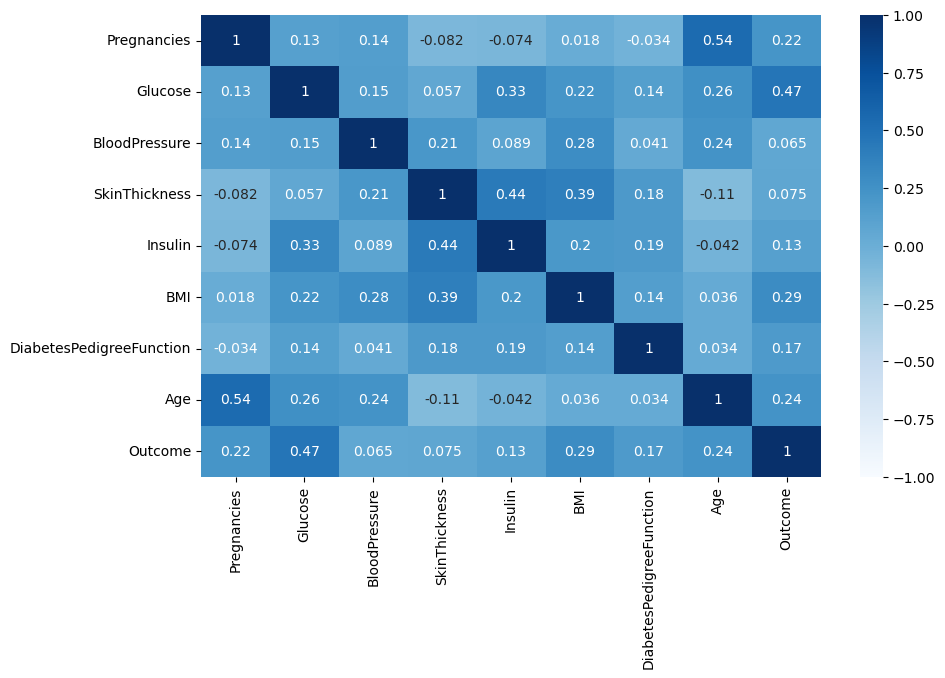

In [195]:
fig_correl = plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),
           cmap = 'Blues',
           vmin=-1, vmax=1,
           annot=True);

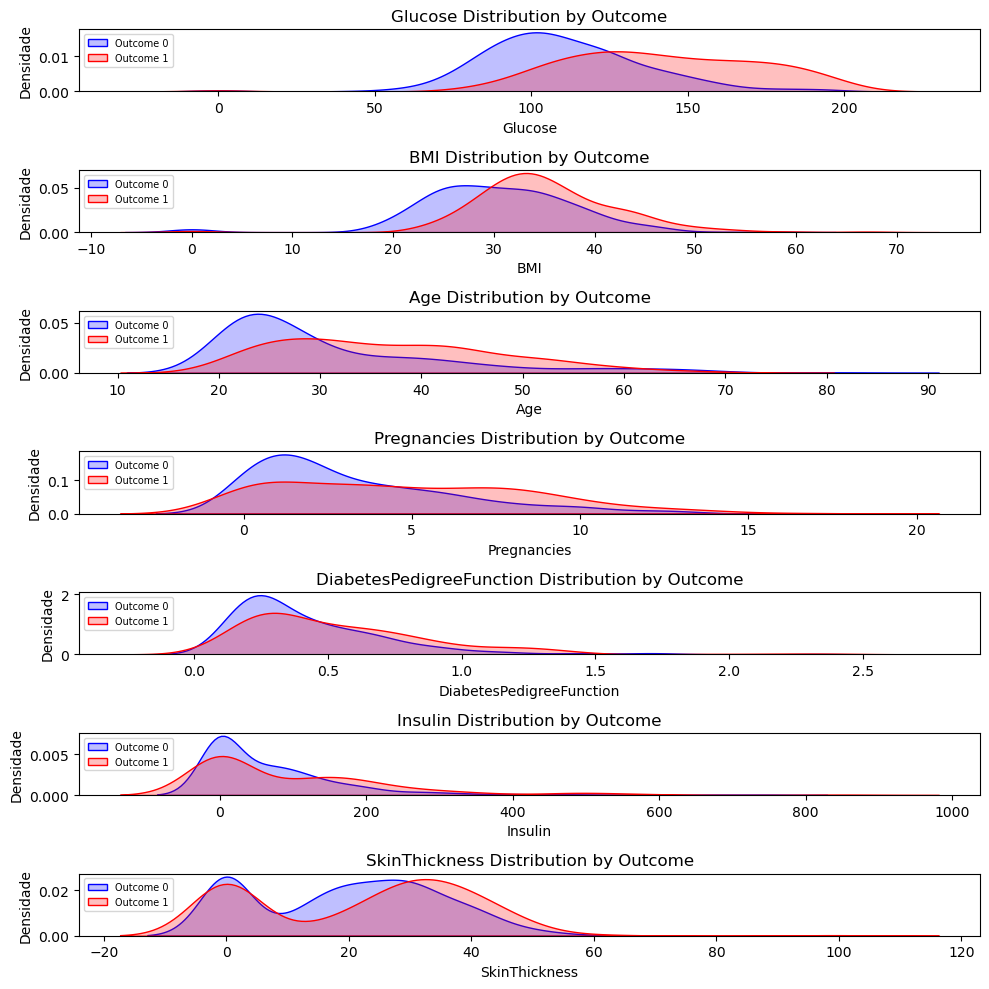

In [196]:
import warnings
warnings.filterwarnings("ignore")

# Correlation Matrix
corr_matrix = df.corr()

# Selecting the top features (by correlation with Outcome)
top_features = corr_matrix['Outcome'].drop('Outcome').abs().nlargest(7).index

# Creating distribution plots for each explanation variable
fig, axes = plt.subplots(7, 1, figsize=(10, 10)) 

for i, feature in enumerate(top_features):
    ax = axes[i]
    
    # KDE plot for Outcome = 0
    sns.kdeplot(df[df['Outcome'] == 0][feature], label='Outcome 0', color='blue', shade=True, ax=ax)
    
    # KDE plot for Outcome = 1
    sns.kdeplot(df[df['Outcome'] == 1][feature], label='Outcome 1', color='red', shade=True, ax=ax)
    
    ax.set_title(f'{feature} Distribution by Outcome')
    ax.set_xlabel(feature)
    ax.set_ylabel('Densidade')
    ax.legend(loc='upper left', fontsize=7)

plt.tight_layout()
plt.show()


### Initial Solution - Mathematical Modeling

We'll use a logistic regression method to build a data model that, given the following variables:

- Pregnancies ($x_1$)
- Glucose ($x_2$)
- BloodPressure ($x_3$)
- SkinThickness ($x_4$)
- Insulin ($x_5$)
- BMI ($x_6$)
- DiabetesPedigreeFunction ($x_7$)
- Age ($x_8$)

Estimates whether the observed person is a diabetic patient or not, using the following linear relation for the modelling process: 

$$ z = \beta_0 + \beta_1*x_1 + \beta_2*x_2 + \beta_3*x_3 + \beta_4*x_4 + \beta_5*x_5 + \beta_6*x_6 + \beta_7*x_7 + \beta_8*x_8  $$

Where $\beta_0$ is the intercept value and {$\beta_1$, $\beta_2$,..., $\beta_8$} is the set of the respective angular coefficients for the explanatory variables set {$x_1$, $x_2$,...,$x_8$} of the linear regression model used to generate the logistic regression model


For estimation, the model will use the sigmoid (logistic) transformation

$$P(Y=1) = g(z) = 1/(1+exp(-z))$$

And will use, initially, the value P(Y=1) = 0.5 as a threshold for estimation 1 (diabetic patient) or 0 (non-diabetic patient).

In [197]:
#Variables definition & model fitting

x = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']]
y = df['Outcome']

model = LogisticRegression(random_state=0, fit_intercept=True, max_iter=1000)
model_fit = model.fit(x,y)
model_fit

LogisticRegression(max_iter=1000, random_state=0)

In [198]:
print(f'Intercept : {model.intercept_[0]}')
print(f'Coefficients: {model.coef_[0]}')

print(f'''
The linear regression will be expressed as:

z(x1, x2,...,x8) = {round(model.coef_[0][0], 4)}*x_1 + {round(model.coef_[0][1], 4)}*x_2 + {round(model.coef_[0][2], 4)}*x_3 + {round(model.coef_[0][3], 4)}*x_4 + {round(model.coef_[0][4], 4)}*x_5 + {round(model.coef_[0][5], 4)}*x_6 + + {round(model.coef_[0][6], 4)}*x_7 + {round(model.coef_[0][7], 4)}*x_8
''')

Intercept : -8.365027849285202
Coefficients: [ 1.22496323e-01  3.51103783e-02 -1.32992527e-02  7.80204176e-04
 -1.17381408e-03  8.96511441e-02  8.67803387e-01  1.49833015e-02]

The linear regression will be expressed as:

z(x1, x2,...,x8) = 0.1225*x_1 + 0.0351*x_2 + -0.0133*x_3 + 0.0008*x_4 + -0.0012*x_5 + 0.0897*x_6 + + 0.8678*x_7 + 0.015*x_8



In [199]:
df['Estimated_Prob'] = model.predict_proba(x)[:, 1]
df['Estimated_Outcome'] = np.where(df['Estimated_Prob']>= 0.5, 1, 0) #Threshold of 50% for categorizing 1 or 0
df['Model_Check'] = np.where(df['Outcome'] == df['Estimated_Outcome'], 1, 0)

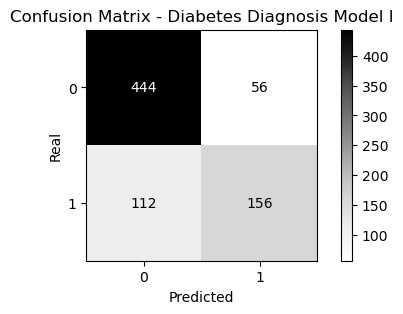

In [200]:
#Confusion Matrix
cm = confusion_matrix(df['Outcome'], df['Estimated_Outcome'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(6, 3))  
disp.plot(cmap="Greys", values_format=".0f", ax=ax)
plt.title("Confusion Matrix - Diabetes Diagnosis Model I")
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.show()

In [201]:
true_negative = cm[0][0]
false_positive = cm[0][1]
false_negative = cm[1][0]
true_positive = cm[1][1]

precision = true_positive/(true_positive + false_positive)
sensibility_tpr = true_positive/(true_positive + false_negative)
specificity_tnr = true_negative/(true_negative+false_positive) 
false_positive_rate = 1-specificity_tnr
false_negative_rate = false_negative/(true_positive+false_negative)

print('''
True Positive  | TP = {}
False Positive | FP = {}
True Negative  | TN = {}
False Negative | FN = {}

|------------------------|

METRICS - Threshold P(Y=1) = 50%

Precision = {:.2%}
Sensibility (TPR) = {:.2%}
Specificity (TNR) = {:.2%}
False Positive Rate = {:.2%}
False Negative Rate = {:.2%}
'''.format(true_positive, false_positive, true_negative, false_negative, precision, sensibility_tpr, specificity_tnr, false_positive_rate, false_negative_rate)
     )




True Positive  | TP = 156
False Positive | FP = 56
True Negative  | TN = 444
False Negative | FN = 112

|------------------------|

METRICS - Threshold P(Y=1) = 50%

Precision = 73.58%
Sensibility (TPR) = 58.21%
Specificity (TNR) = 88.80%
False Positive Rate = 11.20%
False Negative Rate = 41.79%



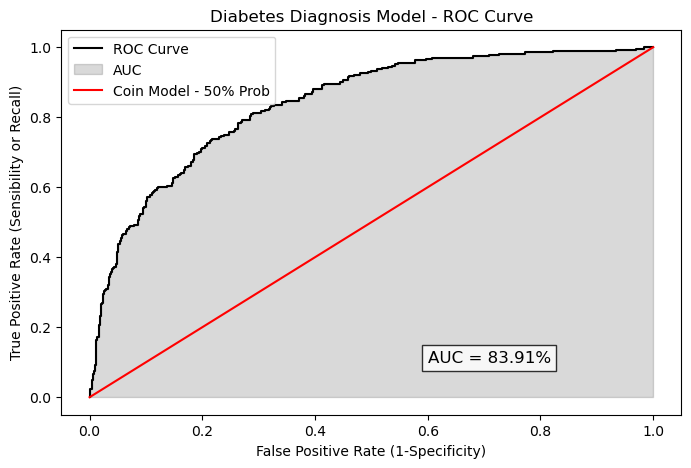

In [202]:
fpr, tpr, thresholds = roc_curve(df['Outcome'], df['Estimated_Prob'])
plt.figure(figsize=(8,5))

plt.plot(fpr, tpr, label='ROC Curve', color='black')
plt.fill_between(fpr, tpr, color='black', alpha=0.15, label='AUC')
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), color='red', label='Coin Model - 50% Prob')


auc_score = roc_auc_score(df['Outcome'], df['Estimated_Prob'])
plt.text(0.6, 0.1, f"AUC = {auc_score:.2%}", fontsize=12, color="black", bbox=dict(facecolor="white", alpha=0.8))


plt.title("Diabetes Diagnosis Model - ROC Curve")
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensibility or Recall)')
plt.legend();

### Analysis of the Performance Metrics - Model I

Although our model shows strong Precision (73.58%), Specificity (88.80%), and AUC (83.9%), the high False Negative Rate (42%) poses a serious risk—many diabetic women could be misdiagnosed as healthy.

To address this, we'll lower the threshold, increasing True Positive detection at the cost of more False Positives—a trade-off that ensures fewer missed diagnoses, which is far more critical in this scenario.

In [203]:
# Assume that df['Outcome'] contains the actual values ​​and df['Estimated_Prob'] are the model probabilities
fpr, tpr, thresholds = roc_curve(df['Outcome'], df['Estimated_Prob'])

# Calculating Youden's J to find the best threshold
youden_j = tpr - fpr
best_threshold = thresholds[np.argmax(youden_j)]

print(f'Best threshold: {best_threshold:.4f}')

Best threshold: 0.2970


Second Solution - Mathematical Re-Modeling

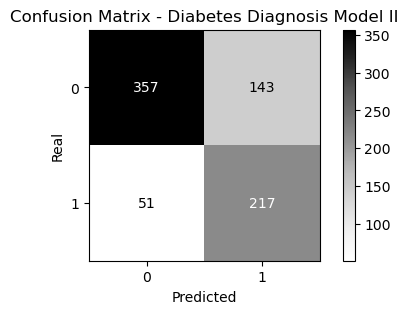

In [204]:
df2 = df.copy()

x_2 = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']]
y_2 = df['Outcome']

model_2 = LogisticRegression(random_state=0, fit_intercept=True, max_iter=1000)
model_2_fit = model_2.fit(x_2,y_2)

df2['Estimated_Prob'] = model_2.predict_proba(x_2)[:, 1]
df2['Estimated_Outcome'] = np.where(df2['Estimated_Prob'] >= best_threshold, 1, 0) #Using best Threshold ~30%
df2['Model_Check'] = np.where(df2['Outcome'] == df2['Estimated_Outcome'], 1, 0)

#Confusion Matrix - Model 2
cm_2 = confusion_matrix(df2['Outcome'], df2['Estimated_Outcome'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_2)
fig, ax = plt.subplots(figsize=(6, 3))  
disp.plot(cmap="Greys", values_format=".0f", ax=ax)
plt.title("Confusion Matrix - Diabetes Diagnosis Model II")
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.show()

In [205]:
true_negative = cm_2[0][0]
false_positive = cm_2[0][1]
false_negative = cm_2[1][0]
true_positive = cm_2[1][1]

precision = true_positive/(true_positive + false_positive)
sensibility_tpr = true_positive/(true_positive + false_negative)
specificity_tnr = true_negative/(true_negative+false_positive) 
false_positive_rate = 1-specificity_tnr
false_negative_rate = false_negative/(true_positive+false_negative)

print('''
True Positive  | TP = {}
False Positive | FP = {}
True Negative  | TN = {}
False Negative | FN = {}

|------------------------|

METRICS - Threshold P(Y=1) = 30%

Precision = {:.2%}
Sensibility (TPR) = {:.2%}
Specificity (TNR) = {:.2%}
False Positive Rate = {:.2%}
False Negative Rate = {:.2%}
'''.format(true_positive, false_positive, true_negative, false_negative, precision, sensibility_tpr, specificity_tnr, false_positive_rate, false_negative_rate)
     )


True Positive  | TP = 217
False Positive | FP = 143
True Negative  | TN = 357
False Negative | FN = 51

|------------------------|

METRICS - Threshold P(Y=1) = 30%

Precision = 60.28%
Sensibility (TPR) = 80.97%
Specificity (TNR) = 71.40%
False Positive Rate = 28.60%
False Negative Rate = 19.03%



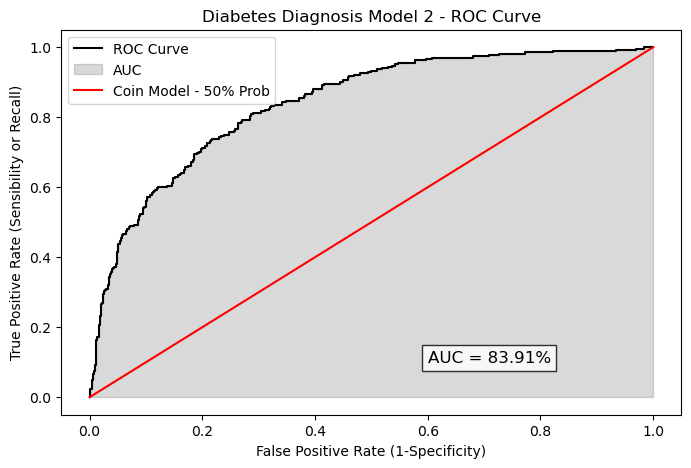

In [206]:
fpr2, tpr2, thresholds2 = roc_curve(df2['Outcome'], df2['Estimated_Prob'])
plt.figure(figsize=(8,5))

plt.plot(fpr2, tpr2, label='ROC Curve', color='black')
plt.fill_between(fpr2, tpr2, color='black', alpha=0.15, label='AUC')
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), color='red', label='Coin Model - 50% Prob')


auc_score2 = roc_auc_score(df2['Outcome'], df2['Estimated_Prob'])
plt.text(0.6, 0.1, f"AUC = {auc_score2:.2%}", fontsize=12, color="black", bbox=dict(facecolor="white", alpha=0.8))


plt.title("Diabetes Diagnosis Model 2 - ROC Curve")
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensibility or Recall)')
plt.legend();

In [207]:
import pandas as pd

class ConfusionMatrixMetrics:
    def __init__(self, cm, threshold=0.30):
        """
        Initializes the confusion matrix and calculates the metrics.

        Parameters:
        - cm: Confusion matrix (2x2 array).
        - threshold: Probability cutoff.
        """
        self.cm = cm
        self.threshold = threshold
        self.true_negative = cm[0][0]
        self.false_positive = cm[0][1]
        self.false_negative = cm[1][0]
        self.true_positive = cm[1][1]
        self._calculate_metrics()

    def _calculate_metrics(self):
        """Calculate metrics from confusion matrix."""
        self.precision = self.true_positive / (self.true_positive + self.false_positive)
        self.sensibility_tpr = self.true_positive / (self.true_positive + self.false_negative)
        self.specificity_tnr = self.true_negative / (self.true_negative + self.false_positive)
        self.false_positive_rate = 1 - self.specificity_tnr
        self.false_negative_rate = self.false_negative / (self.true_positive + self.false_negative)

    def get_metrics_dict(self):
        """Returns dictionary with metrics."""
        return {
            "Threshold": f"{self.threshold:.0%}",
            "Precision": f"{self.precision:.2%}",
            "Sensibility (TPR)": f"{self.sensibility_tpr:.2%}",
            "Specificity (TNR)": f"{self.specificity_tnr:.2%}",
            "False Positive Rate": f"{self.false_positive_rate:.2%}",
            "False Negative Rate": f"{self.false_negative_rate:.2%}",
        }


metrics_1 = ConfusionMatrixMetrics(cm, threshold=0.50)
metrics_2 = ConfusionMatrixMetrics(cm_2, threshold=best_threshold)

comparison_df = pd.DataFrame({
    "Metric": list(metrics_1.get_metrics_dict().keys()),
    "Model 1 (50%)": list(metrics_1.get_metrics_dict().values()),
    "Model 2 (30%)": list(metrics_2.get_metrics_dict().values()),
})

display(comparison_df)
#print(comparison_df.to_string(index=False))

,Metric,Model 1 (50%),Model 2 (30%)
0,Threshold,50%,30%
1,Precision,73.58%,60.28%
2,Sensibility (TPR),58.21%,80.97%
3,Specificity (TNR),88.80%,71.40%
4,False Positive Rate,11.20%,28.60%
5,False Negative Rate,41.79%,19.03%


### Conclusion

    Model 2 seems to be the better choice because it has a higher Sensitivity (TPR) (81%) and lower False Negative (19%), meaning it is more likely to correctly identify women who have diabetes. 
    
    In a medical context, it’s crucial to minimize False Negatives (FNR), as missing a diagnosis could have severe consequences for the patient. 
    
    Although Model 2 has a higher False Positive Rate (FPR), the trade-off is acceptable in medical applications, as false positives can be further verified through additional testing, while missing a true case (false negative) is more problematic.